# Importing all the Libraries

In [229]:
import os
import pandas as pd
import numpy as np
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')


# Reading the data

In [230]:
df1 = pd.read_excel(
     os.path.join('Final_data_prepared.xlsx'),
     engine='openpyxl',
)

In [231]:
df1.drop(['Unnamed: 0'],axis=1,inplace=True)

# Data Preprocessing

Removing the punctuations

In [232]:
def remove_punctuation(text):
    '''Remove all the punctuations from a text.
    
    Input: a string or text data
    Output: text without punctuations
    '''
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#storing the puntuation free text
df1['Leaf']= df1['Leaves'].apply(lambda x:remove_punctuation(x))
df1['Description']= df1['new_column'].apply(lambda x:remove_punctuation(x))


In [233]:
df1.head()

,Leaves,new_column,Leaf,Description
0,Patient Diaries',ePRO and eCOA,Patient Diaries,ePRO and eCOA
1,Patient Diaries',A single checkbox allows you to set either a c...,Patient Diaries,A single checkbox allows you to set either a c...
2,Patient Diaries',And your ePRO data is HIPAA compliant and ful...,Patient Diaries,And your ePRO data is HIPAA compliant and ful...
3,Patient Diaries',Deploy an ePRO experience with images video ...,Patient Diaries,Deploy an ePRO experience with images video ...
4,Patient Diaries',From patient friendly ePRO to system interoper...,Patient Diaries,From patient friendly ePRO to system interoper...


In [234]:
df1.drop(['Leaves','new_column'],axis=1,inplace=True)

Lowering the text

In [235]:
def lower_text(text):
    ''' Convert all the characters of a string to lowercase
    
    Input: a string or text data
    Output: a lowercased string
    '''
    return text.lower()
df1['Description']= df1['Description'].apply(lambda x: lower_text(x))   

Tokenization

In [236]:
import re
def tokenization(text):
    '''convert the string into list of strings calles tokens
    
    Input: a string or text data
    Output: tokenized list
    '''
    tokens = text.split(' ')
    return tokens
df1['Description_']= df1['Description'].apply(lambda x: tokenization(x))

Remove empty strings from list

In [237]:
def remove_empty(list_tokens):
    '''Removes the empty element from a list.
    
    Input: a list of strings
    Output: list without empty strings
    '''
    str_list = list(filter(None, list_tokens))
    return str_list
df1['Description']= df1['Description_'].apply(lambda x: remove_empty(x))   

In [238]:
df1=df1[['Leaf','Description']]

Removing stop words

In [239]:
import nltk
stopwords = nltk.corpus.stopwords.words('english')
stopwords[0:10]


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [240]:
def remove_stopwords(list_tokens):
    '''Removes all the stopwords present in a list of strings
    
    Input: a list of strings
    Output: a list of strings without any  stopwords
    '''
    output= [i for i in list_tokens if i not in stopwords]
    return output

In [241]:
df1['Description']= df1['Description'].apply(lambda x:remove_stopwords(x))


Lemmetization on description column

In [242]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [243]:
def lemmatizer(list_tokens):
    '''convert the strings in a list into lemetized strings
    
    Input: a list of strings
    Output: a lemetized list of strings 
    '''
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in list_tokens]
    return lemm_text
df1['Description']=df1['Description'].apply(lambda x:lemmatizer(x))

Join the text list into one single string

In [244]:
def join_text(token_list):
    '''convert the list of strings into a single string
    
    Input: a list of strings
    Output: a joined single string from all the strings in a list 
    '''
    
    return " ".join(token_list)
df1['Description']=df1['Description'].apply(lambda x:join_text(x))

Droping the duplicates

In [245]:
df1=df1.drop_duplicates(keep='first',inplace=False).reset_index(drop=True)
df1

,Leaf,Description
0,Patient Diaries,epro ecoa
1,Patient Diaries,single checkbox allows set either clinician ba...
2,Patient Diaries,epro data hipaa compliant fully auditable
3,Patient Diaries,deploy epro experience image video visual anal...
4,Patient Diaries,patient friendly epro system interoperability ...
...,...,...
365,Biostatistics,adaptive clinical trial design expert clinical...
366,Biostatistics,biostatistic service
367,Biostatistics,biostatistics programming analysis
368,Biostatistics,biostatistics biostatistic service medical wri...


Lable Encoding

In [246]:
le = preprocessing.LabelEncoder()
df1['Leaf'] = le.fit_transform(df1.Leaf.values)

Data Segregation

In [247]:
X=df1['Description']

In [248]:
y=df1['Leaf']

Using Cross Validation to split the data

In [249]:
from sklearn.model_selection import StratifiedKFold


In [250]:
text_clf = Pipeline([
    ('vect', TfidfVectorizer(max_features=100)),
    ('clf', MultinomialNB()),
])

# Applying Naive Bayes Classifer

In [251]:
skf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
accuracy=[]
precision=[]
recall=[]
curr_max=0
for train_index,test_index in skf.split(X,y):
#     print("Train:",train_index,'Test:',test_index)
    X_train,X_test = X[train_index], X[test_index]
    y_train,y_test = y[train_index], y[test_index]
    text_clf.fit(X_train, y_train)
    docs_test = X_test
    predicted = text_clf.predict(docs_test)
    accuracy.append(np.mean(predicted == y_test)*100)
    if curr_max<np.mean(predicted == y_test)*100:
        curr_max=np.mean(predicted == y_test)*100
        y_test_max=y_test
        y_pred_max=predicted
    precision.append(metrics.precision_score(y_test, predicted, pos_label=1,average='weighted'))
    recall.append(metrics.recall_score(y_test, predicted, pos_label=1,average='weighted'))
    print('We got an accuracy of',np.mean(predicted == y_test)*100, '% over the test data.')
    print('precision ',metrics.precision_score(y_test, predicted, pos_label=1,average='weighted'))
    print('recall ',metrics.recall_score(y_test, predicted, pos_label=1,average='weighted'))
    print('-------------------------------------------------------------------')


We got an accuracy of 83.78378378378379 % over the test data.
precision  0.8096436957917034
recall  0.8378378378378378
-------------------------------------------------------------------
We got an accuracy of 78.37837837837837 % over the test data.
precision  0.7431829150579151
recall  0.7837837837837838
-------------------------------------------------------------------
We got an accuracy of 75.67567567567568 % over the test data.
precision  0.7279006279006279
recall  0.7567567567567568
-------------------------------------------------------------------
We got an accuracy of 81.08108108108108 % over the test data.
precision  0.8020198580543408
recall  0.8108108108108109
-------------------------------------------------------------------
We got an accuracy of 79.72972972972973 % over the test data.
precision  0.7747638962060214
recall  0.7972972972972973
-------------------------------------------------------------------


In [252]:
print('Overall Accuracy ',sum(accuracy)/len(accuracy))
print('Overall precision ',(sum(precision)/len(precision))*100)
print('Overall recall ',(sum(recall)/len(recall)*100))

Overall Accuracy  79.72972972972973
Overall precision  77.15021986021218
Overall recall  79.72972972972973


# Confusion Matrix

In [253]:
from sklearn.metrics import confusion_matrix


In [254]:
last_matrix = confusion_matrix(y_test,predicted, labels=[0,1,2,3,4,5])


In [255]:
matrix = confusion_matrix(y_test_max,y_pred_max, labels=[0,1,2,3,4,5])


In [256]:
le.classes_

array(['Biostatistics', 'Clinical Support', 'Data Management',
       'Medical Writing', 'Patient Diaries', 'Statistical Programming'],
      dtype=object)

<AxesSubplot:>

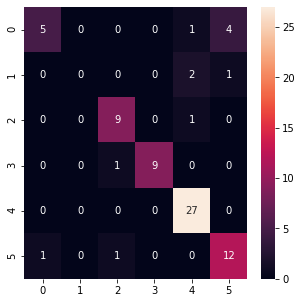

In [257]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize = (5,5))
sn.heatmap(matrix, annot=True)

<AxesSubplot:>

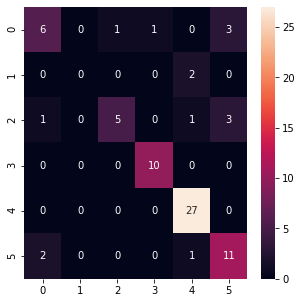

In [258]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize = (5,5))
sn.heatmap(last_matrix, annot=True)

### Defining a function for prediction on a single string

In [259]:
def get_classifications(text):
    '''Text preprosessing such as removal of punctuations,
    lowering the text, tokenization, lemmetization etc will be done.
    
    Input: a string or text data
    Output: Classified label of the input text
    '''
    text_without_punctuations=remove_punctuation(text)
    text_lower=lower_text(text_without_punctuations)
    list_tokens=tokenization(text_lower)
    list_tokens_without_empty_elements=remove_empty(list_tokens)
    list_without_stopwords=remove_stopwords(list_tokens_without_empty_elements)
    lemetized_list=lemmatizer(list_without_stopwords)
    preprocessed_string=join_text(lemetized_list)
    predicted_label= text_clf.predict([preprocessed_string])
    if predicted_label[0] == 5:
        return 'Statistical Programming'
    elif predicted_label[0] == 4:
        return 'Patient Diaries'
    elif predicted_label[0] == 3:
        return 'Medical Writing'
    elif predicted_label[0] == 2:
        return 'Data Management'
    elif predicted_label[0] == 1:
        return 'Clinical Support'
    else:
        return 'Biostatistics'

    

## Some Example Predictions

Defining the text

In [260]:
text1='ePRO is fully integrated with OpenClinicas EDC  so data managers and other study designers enjoy creating the forms in one system and in one place'

In [261]:
text1

'ePRO is fully integrated with OpenClinicas EDC  so data managers and other study designers enjoy creating the forms in one system and in one place'

Function Call

In [262]:
get_classifications(text1)

'Patient Diaries'

In [263]:
text2='global  biometrics  cro  statistics  programming  clinical  datamanagement  science  contract research  reporting  trial  fsp  specialist  iss  ise  cdisc  rwe  real world evidence  risk based monitoring'

In [264]:
text2

'global  biometrics  cro  statistics  programming  clinical  datamanagement  science  contract research  reporting  trial  fsp  specialist  iss  ise  cdisc  rwe  real world evidence  risk based monitoring'

In [265]:
get_classifications(text2)

'Statistical Programming'

In [266]:
text3='All eCS clinical trial data management services employ elluminate Data Central and Clinical Analytics'

In [267]:
text3

'All eCS clinical trial data management services employ elluminate Data Central and Clinical Analytics'

In [268]:
get_classifications(text3)

'Data Management'

In [269]:
text4='Medical Writing is an integral part of clinical research and our team of specialist medical writers deliver accurate  timely  and cost effective clinical and regulatory documents to the highest quality and scientific standards '

In [270]:
text4

'Medical Writing is an integral part of clinical research and our team of specialist medical writers deliver accurate  timely  and cost effective clinical and regulatory documents to the highest quality and scientific standards '

In [271]:
get_classifications(text4)

'Medical Writing'